# 2. Preprocessing
## 2.02 Feature engineering in time

The goal of this notebook is to include all relevant *time dependent* information in the predictors. This is utmost importance since otherwise the model is not able to learn the time dependent information in the Dense neural net/multi-layer perceptron architecture of the neural net. Also the Recurrent neural net/LSTM architecture needs the time information but not in the form of additional variables, but a reshaped original array. 

Goal: Add previous and future days precipitation
to have the appropriate features for 
- the Time-delay neural network, or
- the LSTM neural net.


### Workflow outline
1. Load data
2. Selecting the predictand gridpoint
3. **Prepare time delay features**




In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

## 1. Loading the data
Sample dataset contained in the git repository.

As you are reading these lines, you opened the notebook in the `./docs/` folder of the main repository directory. To access the sample dataset that was delivered to you with the code, step outside the current directory (`../`) and enter the `data/` folder. The names of the sample datasets are `smallsampledata-era5.nc` and `smallsampledata-glofas.nc`, both in netCDF format, a user-friendly format that keeps the file size low and stores meta-data within the file.

We use `xarray` to access the files, as it provides us with a very powerful interface to work with the data. Let's open the files and see what's in there:

In [2]:
era5 = xr.open_dataset('../../data/smallsampledata-era5.nc')

In [3]:
glofas = xr.open_dataset('../../data/smallsampledata-glofas.nc')

Its datatype is `xarray.Dataset`, containing a spatio-temporal subset of 5 variables that we selected from the original ERA5 dataset. It also contains one derived variable (`rtp_500-850`) that is used in Meteorology quite a bit because it is proportional to mass-weighted mean temperature of the air, in this case between 850 and 500 hPa. It could be an additional predictor to classify the weather regime.

In [4]:
era5

<xarray.Dataset>
Dimensions:      (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * time         (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude    (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude     (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Data variables:
    cp           (time, latitude, longitude) float32 ...
    lsp          (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    tcwv         (time, latitude, longitude) float32 ...
    ro           (time, latitude, longitude) float32 ...
    rtp_500-850  (time, latitude, longitude) float32 ...

To access a variable's description, select one like this:

In [5]:
era5['cp']

<xarray.DataArray 'cp' (time: 5478, latitude: 13, longitude: 25)>
[1780350 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
  * longitude  (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude   (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
Attributes:
    standard_name:  lwe_thickness_of_convective_precipitation_amount
    long_name:      Convective precipitation
    units:          m

### 1.a) Selecting useful predictor variables
The variable selection has already been done by us when preparing the small sample datasets for you, so you can use them straight away. What is still necessary is clustering and reshaping the input data dimension, because the dimensionality of the raw input data would be too high: 

To give a rough estimate, imagine using all GloFAS and ERA5 gridpoints of the upstream area of one point. For 1.5x1.5  degree (lat,lon), ERA5 provides 6 x 6 and GloFAS 15 x 15 gridpoints. To take the time dimension into account we'd need, say, 10 days of discharge and 180 days of precipitation. 

Summing up, this makes the raw input dimensionality 15 x 15 x 10 and 6 x 6 x 180, in total ~8700 features, where most of the predictors won't vary that much from one gridpoint to another in the upstream area (large scale temperature, total-column water vapor).

To continue, we need to 
  1. spatially aggregate and 
  2. temporally aggregate the data (i.e., reduce dimensionality). 
  
Both will be done in sections below, but first we need to define which point we will be making forecasts for.

## 2. Selecting the predictand
This point is noted here for completeness. Basically you will need to know for which gridpoint you plan to do predictions before preparing the predictors/features.

The target variable shall be the discharge at the point where the Danube river leaves the data domain. This is given by the point within the catchment where the discharge is the highest, so we first filter by the catchment basin shapefile (Worldbank dataset "Global River Basins") and then look for the maximum discharge. It is at `latitude=48.35, longitude=13.95`.

To select the basin from the shapefile, we use a function defined in `./aux/utils.py`. The interested user may have a look there how it is done, but it would obstruct the clarity in this notebook. To import the function it needs to be present in the current processes path. We do that by adding the parent/main directory to `sys.path`. In this way we can import some function in `./aux/utils_floodmodel.py` by `from aux.utils_floodmodel import somefunction`.

In [6]:
import sys
sys.path.append("../../")
from python.aux.utils_floodmodel import get_mask_of_basin

In [7]:
danube_catchment = get_mask_of_basin(glofas['dis'].isel(time=0))
dis = glofas['dis'].where(danube_catchment)

Now we look up the coordinates of the maximum discharge point. We see that the point of interest is at 48.35 degree latitude and 13.95 degree longitude.

In [8]:
maximum = dis.where(dis==dis.max(), drop=True)
lat, lon = float(maximum.latitude), float(maximum.longitude)
lat, lon

(48.35, 13.950000000000017)

/home/srvx11/lehre/users/a1254888/.conda/envs/ml_flood/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


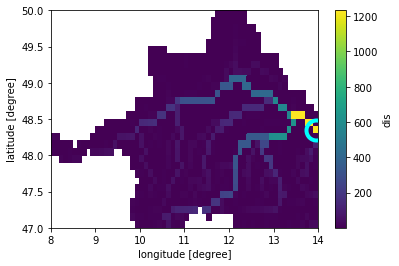

In [9]:
poi = dict(latitude=48.35, longitude=13.95)
dis_mean = dis.mean('time')
dis_mean.plot()
plt.gca().plot(lon, lat, color='cyan', marker='o', 
               markersize=20, mew=4, markerfacecolor='none')

## 3. Time aggregated predictors

### 3.a) For the time-delay neural net
The time series of discharge is approximately shaped by a range of time-lagged precipitation that influences the river discharge. To allow the model to exhibit this time-delay behaviour, we need to add time-lagged predictors/features. If we only included the sum of precipitation of the last, say, 14 days, then the model can not possibly learn true behaviour because the weight matrix of a neural net is not changed anymore after training, meaning that the impact the 14-day sum has on the output is not time dependent. 

Thus the goal is to provide the model predictors that exhibit an increasing shift (1, 2, 3 days ago) and at some point, the precipitation is aggregated within the soil by diffusion which smoothes out peaks in precipitation (see diffusion equation).

To get yesterday's precipitation at the timestamp of today, we can **shift** the data by one day and **add** the resulting timeseries **as additional variable** to the existing dataset.
Start with present day's precipitation.

In [10]:
X = era5[['lsp', 'cp']]

In [11]:
from python.aux.utils_floodmodel import shift_and_aggregate

**1. Shift the precipitation timeseries and add them to the existing dataset.**

To have the precipitation of the last 5  and the next 14 days, iterate over these days.

In [12]:
for var in ['lsp', 'cp']:
    for i in range(1,6):
        newvar = var+'-'+str(i)
        X[newvar] = X[var].shift(time=i)  # previous precip as current day variable

iterate over the next 14 days (day 0 is the first prediction)

In [13]:
for var in ['lsp', 'cp']:
    for i in range(1,14):
        newvar = var+'+'+str(i)
        X[newvar] = X[var].shift(time=-i) # future precip as current day variable
        
X.data_vars

Data variables:
    lsp      (time, latitude, longitude) float32 ...
    cp       (time, latitude, longitude) float32 ...
    lsp-1    (time, latitude, longitude) float32 nan nan ... 8.196841e-05
    lsp-2    (time, latitude, longitude) float32 nan nan ... 0.00036743758
    lsp-3    (time, latitude, longitude) float32 nan nan ... 1.4202446e-05
    lsp-4    (time, latitude, longitude) float32 nan nan ... 0.0053772996
    lsp-5    (time, latitude, longitude) float32 nan nan ... 0.016994901
    cp-1     (time, latitude, longitude) float32 nan nan ... 0.00027301
    cp-2     (time, latitude, longitude) float32 nan nan nan nan ... 0.0 0.0 0.0
    cp-3     (time, latitude, longitude) float32 nan nan nan nan ... 0.0 0.0 0.0
    cp-4     (time, latitude, longitude) float32 nan nan ... 7.6766744e-05
    cp-5     (time, latitude, longitude) float32 nan nan ... 0.001220766
    lsp+1    (time, latitude, longitude) float32 0.0049987715 0.00515422 ... nan
    lsp+2    (time, latitude, longitude) flo


**2. Aggregate over an increasing number of days as we iterate back in time.**

Now for precipitation that is already some days ago we will aggregate over some days because it does not really matter at some point if a certain precipitation was 30 or 31 days ago. We account for up to 180 days old precipitation.


Apply `shift_and_aggregate` before spatially interpolating the fields to avoid `MemoryError`s.


In [14]:
X['lsp-5-11'] = shift_and_aggregate(X['lsp'], shift=5, aggregate=7)
X['lsp-12-25'] = shift_and_aggregate(X['lsp'], shift=12, aggregate=14)
X['lsp-26-55'] = shift_and_aggregate(X['lsp'], shift=26, aggregate=30)
X['lsp-56-180'] = shift_and_aggregate(X['lsp'], shift=56, aggregate=125)

### How does that look in a time series plot?

The peaks are dampened the further we go back in time and the precipitation is 'spread out in time'.

Text(0.5, 1.0, 'Example timeseries of predictors')

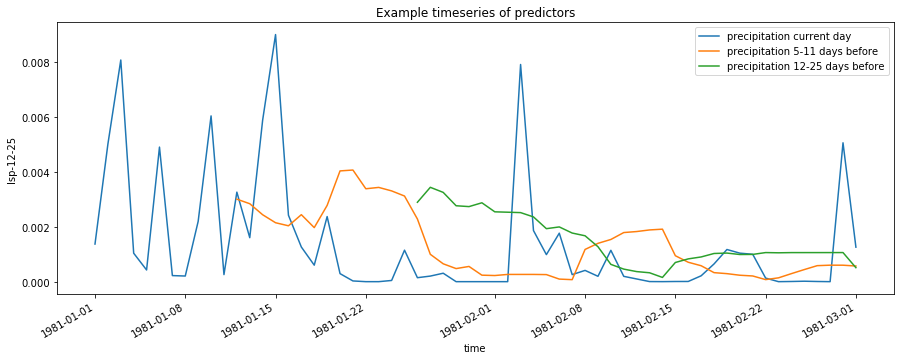

In [15]:
fig, ax = plt.subplots(figsize=(15,5))

X['lsp'][:60,0,0].plot(ax=ax, label='precipitation current day')
X['lsp-5-11'][:60,0,0].plot(ax=ax, label='precipitation 5-11 days before')
X['lsp-12-25'][:60,0,0].plot(ax=ax, label='precipitation 12-25 days before')
ax.legend()
plt.title('Example timeseries of predictors')

In [16]:
X

<xarray.Dataset>
Dimensions:     (latitude: 13, longitude: 25, time: 5478)
Coordinates:
  * longitude   (longitude) float32 8.0 8.25 8.5 8.75 ... 13.25 13.5 13.75 14.0
  * latitude    (latitude) float32 50.0 49.75 49.5 49.25 ... 47.5 47.25 47.0
  * time        (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
Data variables:
    lsp         (time, latitude, longitude) float32 ...
    cp          (time, latitude, longitude) float32 ...
    lsp-1       (time, latitude, longitude) float32 nan nan ... 8.196841e-05
    lsp-2       (time, latitude, longitude) float32 nan nan ... 0.00036743758
    lsp-3       (time, latitude, longitude) float32 nan nan ... 1.4202446e-05
    lsp-4       (time, latitude, longitude) float32 nan nan ... 0.0053772996
    lsp-5       (time, latitude, longitude) float32 nan nan ... 0.016994901
    cp-1        (time, latitude, longitude) float32 nan nan ... 0.00027301
    cp-2        (time, latitude, longitude) float32 nan nan nan ... 0.0 0.0 0.0
    cp-3   

In [25]:
from python.aux.utils_floodmodel import reshape_multiday_predictand

In [26]:
y = glofas['dis'].interp(latitude=lat, longitude=lon)

var = y.name
y = y.to_dataset()
for i in range(1,14):
    newvar = var+'+'+str(i)
    y[newvar] = y[var].shift(time=-i) # future precip as current day variable
y = y.to_array(dim='forecast_day')
y.coords['forecast_day'] = range(1,len(y.forecast_day)+1)
y

<xarray.DataArray (forecast_day: 14, time: 5478)>
array([[798.361572, 792.207703, 796.706116, ..., 783.30896 , 782.144958,
        778.828003],
       [792.207703, 796.706116, 814.23584 , ..., 782.144958, 778.828003,
               nan],
       [796.706116, 814.23584 , 819.019653, ..., 778.828003,        nan,
               nan],
       ...,
       [792.431763, 788.05072 , 783.429138, ...,        nan,        nan,
               nan],
       [788.05072 , 783.429138, 779.090576, ...,        nan,        nan,
               nan],
       [783.429138, 779.090576, 775.803223, ...,        nan,        nan,
               nan]])
Coordinates:
  * time          (time) datetime64[ns] 1981-01-01 1981-01-02 ... 1995-12-31
    latitude      float64 48.35
    longitude     float64 13.95
  * forecast_day  (forecast_day) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14

In [28]:
# aggregate over the space dimension (more complex in the next notebook)
Xagg = X.mean(['latitude', 'longitude'])

Xda, yda = reshape_multiday_predictand(Xagg, y)

Now we have both the X array and the y array which can be used to train the 14 day forecast of the neural network.
But this will be the focus of another part-3 notebook in the folder `notebooks/3_model_tests/`.

---
### 3.b) Predictors for the LSTM neural net
Within the framework of the Long short-term memory (LSTM) neural net, it is necessary to provide 

- the timeseries of the predictand variable (it may **NOT** be aggregated)
- other variables may be incorporated by concatenating 'embeddings', i.e. arbitrary features, to the LSTM layer output before applying a last `Dense` layer (keras).

That means you simply omit the steps of aggregation and stick to the plain shifted timeseries.